# Attendance

[The link to SEAts](https://gold.seats.cloud/angular/#/lectures)

# Today

- **RNNs**
- **NLP toolkit (text vectorisation, word embeddings)**
- **Transformers**

# 13 Timeseries forecasting

In [1]:
import os
import sys
import pathlib

import numpy as np
import tensorflow as tf

from tqdm import tqdm
from matplotlib import pyplot as plt

from IPython.core.magic import register_cell_magic

os.environ["KERAS_BACKEND"] = "jax"

import keras

@register_cell_magic
def backend(line, cell):
    current, required = os.environ.get("KERAS_BACKEND", ""), line.split()[-1]
    if current == required:
        get_ipython().run_cell(cell)
    else:
        print(
            f"This cell requires the {required} backend. To run it, change KERAS_BACKEND to "
            f"\"{required}\" at the top of the notebook, restart the runtime, and rerun the notebook."
        )

---

## A temperature-forecasting example

### Download the data

In [2]:
DATASET_DIR = pathlib.Path("jena")

if not DATASET_DIR.exists():
    !wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
    !unzip jena_climate_2009_2016.csv.zip -d jena

MODELS_DIR = pathlib.Path("models")
MODELS_DIR.mkdir(exist_ok=True)

--2025-12-17 10:23:43--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.37.0, 16.15.179.175, 54.231.198.96, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.37.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  43.0MB/s    in 0.3s    

2025-12-17 10:23:43 (43.0 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena/jena_climate_2009_2016.csv  
  inflating: jena/__MACOSX/._jena_climate_2009_2016.csv  


#### Inspecting the data of the Jena weather dataset

In [3]:
fname = DATASET_DIR / "jena_climate_2009_2016.csv"

with open(fname) as f:
    data = f.read()

lines = data.split("\n")             # split on lines
header = lines[0].split(",")         # first line is our header (split on commas)
lines = lines[1:]                    # our data is all the next lines
for i, feature in enumerate(header): # loop through our header items
    if feature == '"T (degC)"':
        print(f"{i:<2} | \033[1;3m{feature} ← temperature in °C\033[0m")
    else:
        print(f"{i:<2} | {feature}")

print()
print(f"{len(lines)} lines")

0  | "Date Time"
1  | "p (mbar)"
2  | "T (degC)" ← temperature in °C
3  | "Tpot (K)"
4  | "Tdew (degC)"
5  | "rh (%)"
6  | "VPmax (mbar)"
7  | "VPact (mbar)"
8  | "VPdef (mbar)"
9  | "sh (g/kg)"
10 | "H2OC (mmol/mol)"
11 | "rho (g/m**3)"
12 | "wv (m/s)"
13 | "max. wv (m/s)"
14 | "wd (deg)"

420451 lines


#### Parsing the data

In [4]:
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))   # (len minus the date)

if not os.path.isfile(DATASET_DIR / "temperature.npy") and not os.path.isfile(DATASET_DIR / "raw_data.npz"):
    for i, line in tqdm(enumerate(lines), total=len(lines)):
        values = [float(x) for x in line.split(",")[1:]] # (don't take the date)
        temperature[i] = values[1]                       # temperature at index 1
        raw_data[i, :] = values[:]
    np.save(DATASET_DIR / "temperature.npy", temperature)   # save as binary data
    np.save(DATASET_DIR / "raw_data.npy", raw_data)         # (much faster reloads)
else:
    print("loading numpy files")
    temperature = np.load(DATASET_DIR / "temperature.npy")
    raw_data = np.load(DATASET_DIR / "raw_data.npy")

100%|██████████| 420451/420451 [00:01<00:00, 214081.44it/s]


#### Plotting the temperature timeseries

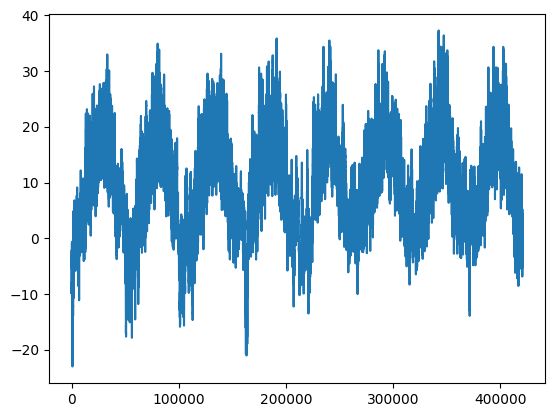

In [5]:
plt.plot(range(len(temperature)), temperature) # globally cyclical

#### Plotting the first 10 days of the temperature timeseries

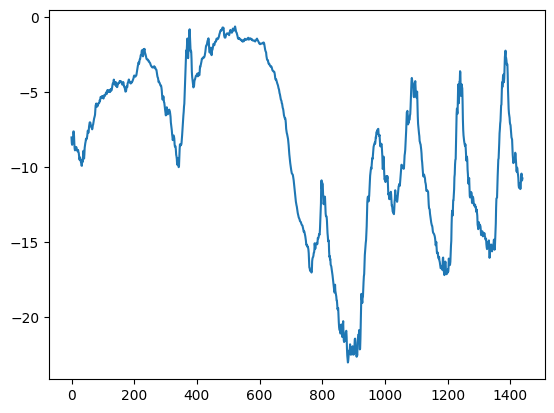

In [6]:
plt.plot(range(1440), temperature[:1440]) # locally much less so

#### Computing the number of samples we'll use for each data split

In [7]:
num_train_samples = int(0.5 * len(raw_data))                           # 50% for training
num_val_samples = int(0.25 * len(raw_data))                            # 25% for validation
num_test_samples = len(raw_data) - num_train_samples - num_val_samples # the rest (25%) for test
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


---

### Preparing the data

#### Normalizing the data

In [8]:
mean = raw_data[:num_train_samples].mean(axis=0) # we use the train data only to normalise
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

#### Inspecting a dummy dataset

What will our dataset look like? A sequence, and a next step.

Documentation for [`keras.utils.timeseries_dataset_from_array`](https://keras.io/api/data_loading/timeseries/).

In [9]:
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],   # given our length, stop 3 before the end
    targets=int_sequence[3:], # the first target will be at the fourth element
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    print("-"*40)
    for i in range(inputs.shape[0]): # loop over batch
        print([int(x) for x in inputs[i]], int(targets[i]))

----------------------------------------
[0, 1, 2] 3
[1, 2, 3] 4
----------------------------------------
[2, 3, 4] 5
[3, 4, 5] 6
----------------------------------------
[4, 5, 6] 7


#### Instantiating datasets for training, validation, and testing

In [10]:
sampling_rate = 6                                  # in the data, one sample every 10 mins: x 6 → one per hour
sequence_length = 120                              # the length of our sequence is 5 days (120 hours)
delay = sampling_rate * (sequence_length + 24 - 1) # target is 24h after the end of the sequence (one day after)
BATCH_SIZE = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],      # not beyond `delay` steps before the end (that's our targets)
    targets=temperature[delay:], # first traget will start at `delay` step after the start
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=BATCH_SIZE,
    start_index=0,
    end_index=num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=BATCH_SIZE,
    start_index=num_train_samples,                           # start after train
    end_index=num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=BATCH_SIZE,
    start_index=num_train_samples + num_val_samples         # start after train & val
)

#### Inspecting the output of one of our datasets

In [11]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


---

### A common-sense, non-machine-learning baseline

What would that look like for continuous data, like temperature?

The assumptions that Chollet make (would it work for UK weather?!) are:

> "In this case, the temperature timeseries can safely be assumed to be continuous (the temperatures tomorrow are likely to be close to the temperatures today) as well as periodical with a daily period. Thus a common-sense approach is to always predict that the temperature 24 hours from now will be equal to the temperature right now." ([DLWP](https://deeplearningwithpython.io/chapters/chapter13_timeseries-forecasting/#a-commonsense-non-machine-learning-baseline))

This is similar to the Boston Housing dataset example we had: calculate the Mean Absolute Error (MAE).

#### Computing the common-sense baseline MAE

In [12]:
def evaluate_naive_method(dataset):
    """Evaluation: the target (in 24h) is identical to the last temperature measurement"""
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        #                   ┌ (the last sample, as our shape is: [samples, step, feature])
        #        (batch ↓)  ↓ (↓ feature at index 1: temperature)
        preds = samples[:, -1, 1] * std[1] + mean[1]     # unnormalize, same mean/std as in training
        total_abs_err += np.sum(np.abs(preds - targets)) # absolute distance between current & in 24h
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


Can we beat this baseline?

A common sense baseline is essential – otherwise we cannot calibrate the performance of any model.

An ML baseline – a simple, cheap model – is also useful.

Our focus is: **are sophisticated models worth the extra computational effort?**

---

### Let's try a basic machine-learning model

Our baseline model is a two layer (plus flattening layer) fully-connected feedforward network.

**Regression task**

The final layer has a single unit without activation.

**Loss**

Mean Squared Error (MSE)

**Metric**

Mean Absolute Error (MAE), so results are directly comparable to the common-sense baseline.

#### Training and evaluating a densely connected model

In [13]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = keras.layers.Reshape((sequence_length * raw_data.shape[-1],))(inputs) # Flatten throws errors
x = keras.layers.Dense(16, activation="relu")(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [14]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 120, 14)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │        26,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,913 (105.13 KB)

 Trainable params: 26,913 (105.13 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        str(MODELS_DIR / "jena_dense.keras"),
        save_best_only=True
    )
]

model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=0,
)

In [16]:
model = keras.models.load_model(MODELS_DIR / "jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 11.7075 - mae: 2.7027
Test MAE: 2.71


We haven't beaten the common sense baseline!

The model is worse than common sense.

The machine is not privy to the wealth of human experiential evidence.

But why hasn't the machine found our simple model: that tomorrow's temperature will be pretty similar to today's?


The hypothesis space is the *space of all two layer networks*.

Already a very complicated space.

The simple baseline might be hidden in a tiny corner of this vast, intricate hypothesis space.

ML limitation: parameter learning can fail to find a simple solution to a simple problem.

Of course we could hard-code models to look for a specific kind of solution but we wish to avoid excessive feature engineering.

#### Plotting results

In [17]:
def plot_history(history):
    loss = history.history["mae"]
    val_loss = history.history["val_mae"]
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, label="Training MAE")
    plt.plot(epochs, val_loss, label="Validation MAE")
    plt.title("Training and validation MAE")
    plt.legend()
    plt.show()

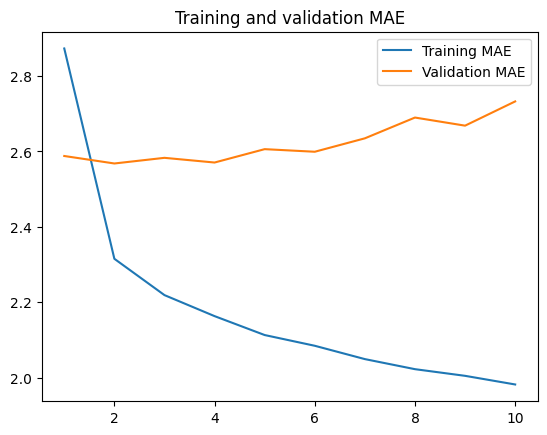

In [18]:
plot_history(history)

---

### Let's try a 1D convolutional model

Convnets extract and modularise salient 2D information from local patches.

1D data – timeseries – might have similar local regularities.

And then 1D convnets would provide a cheap alternative to RNNs.

1D Pooling works just like 2D pooling – max (or average) pooling.

Used for subsampling – reducing the length of 1D inputs.

<!-- <img src="images/convolutions/1d-conv.png"> -->
<img src="https://raw.githubusercontent.com/jchwenger/DLWP/main/lectures/07/images/convolutions/1d-conv.png">

<small>[Castro et al., "STConvS2S: Spatiotemporal Convolutional Sequence to Sequence Network for weather forecasting", ResearchGate](https://www.researchgate.net/figure/Causal-convolution-operation-in-a-1D-convolutional-layer-with-k-3-kernel-size-Input_fig1_337703712)</small>

In [19]:
keras.utils.clear_session()

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
                            # ↓ note the larger convolution window: 24
x = keras.layers.Conv1D(8, 24, activation="relu")(inputs)
x = keras.layers.MaxPooling1D(2)(x)
x = keras.layers.Conv1D(8, 12, activation="relu")(x)
x = keras.layers.MaxPooling1D(2)(x)
x = keras.layers.Conv1D(8, 6, activation="relu")(x)
x = keras.layers.GlobalAveragePooling1D()(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [20]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        str(MODELS_DIR / "jena_conv.keras"),
        save_best_only=True
    )
]

model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=0,
)

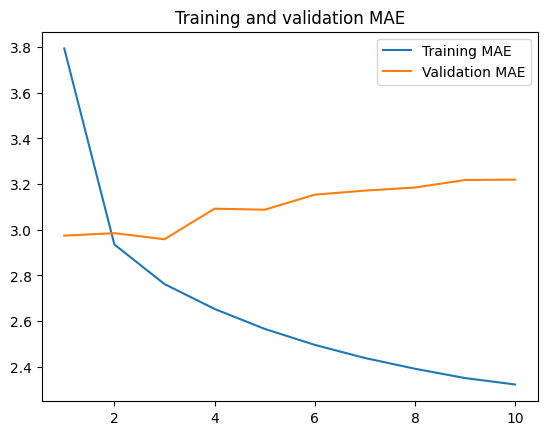

In [21]:
plot_history(history)

In [22]:
model = keras.models.load_model(MODELS_DIR / "jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
del model # Not as good performance as the baseline or RNNs/LSTMs, but cheaper to run!

405/405 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 15.6099 - mae: 3.1115
Test MAE: 3.10


Even worse! What went wrong?

Two things:
- weather data doesn't quite respect translational invariance: patterns are not quite the same in the morning, noon, and evening – invariance only happens at a specific scale;
- *order* in our data matters a lot, with the recent past especially influencing the future: a ConvNet cannot leverage this (DLWP, p. 291)

---

## Recurrent neural networks

Perhaps causality and order matter (weather is not actually random, but follows day-by-day patterns).

We need an order-preserving model – an RNN.

**A simple LSTM-based model**

In [23]:
keras.utils.clear_session()

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = keras.layers.LSTM(16)(inputs) # ← our LSTM
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [24]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 120, 14)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 16)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,001 (7.82 KB)

 Trainable params: 2,001 (7.82 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        str(MODELS_DIR / "jena_lstm.keras"),
        save_best_only=True
    )
]
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=0,
)

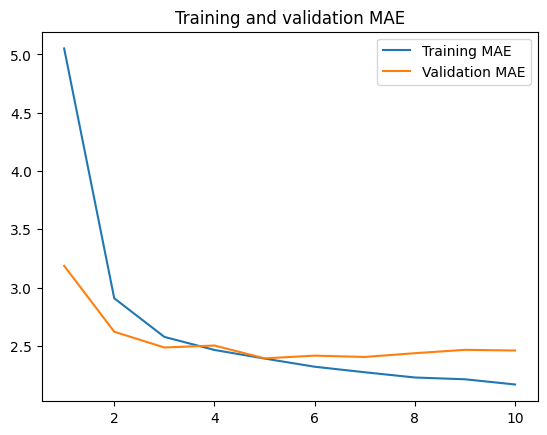

In [26]:
plot_history(history)

In [27]:
model = keras.models.load_model(MODELS_DIR / "jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")  # it is possible to get down to ~2.55 like in the book!

405/405 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 10.9070 - mae: 2.5854
Test MAE: 2.58


---

The dense, fully connected layers and the convnet layers have no memory.

These feedforward networks process each input in turn with no information transfer.

A recurrent neural network (RNN) retains information of past inputs.

### The Simple RNN

The RNN has a **feedback loop**, and the **parameters are shared** (the same at each iteration).

(Saves a lot of parameters, like in CNNs.)

<!-- ![RNN unrolled](images/rnn/RNN-unrolled.png) -->
![RNN unrolled](https://raw.githubusercontent.com/jchwenger/DLWP/main/lectures/07/images/rnn/RNN-unrolled.png)

<small>[Olah, "Understanding LSTM Networks"](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)</small>


The activation $h_{t-1}$ at time $t-1$ is fed back to the input and combined with the new input $x_t$, at time $t$.

The previous activation (layer output) is called the **state** of the unit.

The previous activation/state is weighted and the network learns correlations with earlier inputs by adjusting these weights, in the usual manner.

Here, we imagine that sequence terms $x_1, x_2, x_3, \ldots$ etc. occur at successive times, (even if the sequence is not chronological).

Previously, in a feed forward networks, the entire sequence (review) was treated as a single input vector!

**Note**

The state is reset before a new sequence is processed (if you don't do that your RNN is called **stateful**).


<!-- <img style="height:750px" src="images/rnn/mit.rnn.png"> -->
<img style="height:750px" src="https://raw.githubusercontent.com/jchwenger/DLWP/main/lectures/07/images/rnn/mit.rnn.png">

<small>[Ava Soleimany, MIT 6.S191 (2021): Recurrent Neural Networks](https://www.youtube.com/watch?v=qjrad0V0uJE)</small>

#### RNNs: the maths

There are two inputs: the **current input**, $x_t$, and the **previous state**, $h_{t-1}$.

The state (= activation) of the RNN layer is:

$$
\bbox[5px,border:2px solid red]
{
\begin{align*}
h_t &= f(W \cdot x_t + U \cdot {\color{green} h_{t-1}} + b_h)  \\
\end{align*}
}
$$

$f$: typically: $\color{red}{tanh}$, also sometimes $relu$.  
W is an $M \times N$ matrix – a tensor with shape `(output_features, input_features)`.  
U is an $M \times M$ matrix – a tensor with shape `(output_features, output_features)`.  

$N$: number of input features  
$M$: number of output features = number of units  

That was the **internal mechanism** for the state. To *use* this state and turn it into a prediction, you apply yet another typical operation like so:

$$
\bbox[5px,border:2px solid red]
{
\begin{align*}
y_t &= \sigma(V \cdot h_t + b_y)
\end{align*}
}
$$

$\sigma$: $softmax$, $sigmoid$, depending on your needs.  
V is an $O \times M$ matrix – a tensor with shape `(task_features, output_features)`.  

The previous activation, $h_{t-1}$, can have more or less effect on the current activation.

The influence of the previous activation and input is controlled by the weights.

$
\begin{align*}
The\ recursion: \quad h_t &= f(x_t, \color{blue}{h_{t-1}}) \\
      &= f(x_t, \color{blue}{f( x_{t-1},  \color{green}{h_{t-2}})} ) \\
      &= f( x_t,  \color{blue}{ f( x_{t-1},   \color{green}{f(x_{t-2}, \color{red}{h_{t-3}}) } ) } ) \\
      &= \ldots
\end{align*}
$

In principle, all previous activations, even those reaching far back into the past, can influence the present.


**However**, because of the repeated multiplications involved in the gradient calculation, we quickly get either very large or very small numbers. This is known as the **exploding/vanishing gradient problem**.

#### RNNs: Pseudocode

The simple RNN layer in pseudocode is:

```python
prev_output = 0
for input_t in input_sequence:
                        # ↓ current input | ↓ previous state
    output_t = activation(dot(W, input_t) + dot(U, prev_output) + b)
    prev_output = output_t
```

##### NumPy implementation of a simple RNN

In [28]:
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for i, input_t in enumerate(inputs):
    current = np.dot(W, input_t)
    previous = np.dot(U, state_t)
    output_t = np.tanh(current + previous + b)
    successive_outputs.append(output_t)
    state_t = output_t
    if i == 0:
        print("input_t,  shape:", input_t.shape)
        print("W,        shape:", W.shape)
        print("current,  shape:", current.shape)
        print("U,        shape:", U.shape)
        print("previous, shape:", previous.shape)
        print("b,        shape:", b.shape)
        print("output_t, shape:", output_t.shape)
final_output_sequence = np.stack(successive_outputs, axis=0)

input_t,  shape: (32,)
W,        shape: (64, 32)
current,  shape: (64,)
U,        shape: (64, 64)
previous, shape: (64,)
b,        shape: (64,)
output_t, shape: (64,)


More details in [this notebook](https://github.com/jchwenger/DLWP/blob/main/lectures/07.more/chapter10_dl-for-timeseries_rnn_lstm.ipynb).

#### RNNs: \# of parameters

\begin{align*}
RNNparams &= (current + bias) + previous\\
 &= \bbox[5px,border:2px solid red]{(M \times N + M) + (M \times M)}\\
 &= (M \times N) + (M \times M) + M\\
 &= \bbox[5px,border:2px solid red]{(N + M + 1) \times M}\\
\end{align*}


$N$: number of input features  
$M$: previous output = number of units

Each neuron has $N$ weights for the $N$ input features, $M$ weights for the previous output, and a bias, so $(N + M + 1)$ parameters, but there are $M$ units!

In [29]:
steps = 120
num_features = 32
num_units = 16
inputs = keras.Input(shape=(steps, num_features))
                            # the default
outputs = keras.layers.SimpleRNN(num_units, return_sequences=False)(inputs)
model = keras.Model(inputs,outputs)
model.summary()

print()
print(f"Number of learnable RNN params, (N + M + 1) * M:   {(num_features + num_units  + 1) * num_units}")
print(f"Note: it's the same same as (M * N + M) + (M * M): {(num_units * num_features + num_units) + (num_units * num_units)}")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 120, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 16)             │           784 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 784 (3.06 KB)

 Trainable params: 784 (3.06 KB)

 Non-trainable params: 0 (0.00 B)


Number of learnable RNN params, (N + M + 1) * M:   784
Note: it's the same same as (M * N + M) + (M * M): 784


### The LSTM: Long Short Term Memory

Fully-fledged recurrent nets: LSTMs have a **memory** or **carry** ($C_t$) – passing information forward in time, like a conveyor belt, with potentially no modification – and **gates** ($\sigma$) acting as smooth on/off switches.

The conveyor belt was developed to solve the **exploding/vanishing gradients problem**!  
It is similar to **residual connections** in ConvNets (next week!).

<!-- ![LSTM](images/rnn/dprogrammer.LSTM.png) -->

![LSTM](https://raw.githubusercontent.com/jchwenger/DLWP/main/lectures/07/images/rnn/dprogrammer.LSTM.png)

<small>["RNN, LSTM & GRU", dprogrammer.org](http://dprogrammer.org/rnn-lstm-gru)</small>

More details in [this notebook](https://github.com/jchwenger/DLWP/blob/main/lectures/07.more/chapter10_dl-for-timeseries_rnn_lstm.ipynb).

<!-- <img src="images/rnn/mit.lstm.2.png"> -->
<img src="https://raw.githubusercontent.com/jchwenger/DLWP/main/lectures/07/images/rnn/mit.lstm.2.png">

<small>[Ava Soleimany, MIT 6.S191 (2021): Recurrent Neural Networks](https://www.youtube.com/watch?v=qjrad0V0uJE)</small>

#### Gates

Suppose we wish to turn an RNN off or on.

Simple! Multiply by a binary switch:

$$\delta \times f(t)$$

$\delta$: smooth values between $0, 1$  
$f(t)$: the activation of a simple RNN

What we want:
- the parameters of the switch should be **learnable**;
- because of backpropagation, the process must be **differentiable**: the switch has to be a continuous function – smoothly going from 0 to 1.
  
The smooth activation function that takes values in $[0, 1]$?  
$sigmoid\ (\sigma)$!

##### A learnable gate

$$
\bbox[5px,border:2px solid red]
{
\sigma(z) \odot f(t)
}
$$

$\odot$: the Hadamard (element-wise) product ($\sigma(z)$ and $f(t)$ have the same shape).


But what is $z$?

We might want (because we are processing sequences) the state of the gate – on, off or in between – to depend on the current input and past activations:

$$
\bbox[5px,border:2px solid red]
{
z = W \cdot x_t + U \cdot h_{t-1} + b
}
$$

Our recurrently gated RNN is:

$$
\bbox[5px,border:2px solid red]
{
\sigma(W \cdot x_t + U \cdot h_{t-1} + b) \odot f(t)
}
$$

$\odot$ : the Hadamard (element-wise) product.


#### LSTMs: \# of Learnable parameters

The LSTM follows the same logic as the vanilla RNN, all gates and simple RNN layers have their own parameters $(W, U, b)$, but with **four** internal matrices.

There are four $(W, U, b)$ units – 3 gates and the simple RNN, $f$. Each set of $(W, U, b)$ units has $(N + M + 1) \times M$ trainable parameters

Therefore:

$$
LSTMparams = \bbox[5px,border:2px solid red]{((N + M + 1) \times M) \times 4}
$$

$N$: input features weights  
$M$: previous output = number of units

In [30]:
steps = 120
num_features = 16
num_units = 8
inputs = keras.Input(shape=(steps, num_features))
                                       # the default
outputs = keras.layers.LSTM(num_units, return_sequences=False)(inputs)
model = keras.Model(inputs,outputs)
model.summary()

print()
print(f"Number of learnable LSTM params: { ((num_features + num_units + 1) * num_units) * 4}")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 120, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 8)              │           800 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 800 (3.12 KB)

 Trainable params: 800 (3.12 KB)

 Non-trainable params: 0 (0.00 B)


Number of learnable LSTM params: 800


#### LSTMs: Summary

<!-- <img src="images/rnn/mit.lstm.8.png"> -->
<img style="height:750px" src="https://raw.githubusercontent.com/jchwenger/DLWP/main/lectures/07/images/rnn/mit.lstm.8.png">

<small>[Ava Soleimany, MIT 6.S191 (2021): Recurrent Neural Networks](https://www.youtube.com/watch?v=qjrad0V0uJE)</small>

More information about LSTMs available in [this notebook](https://github.com/jchwenger/DLWP/blob/main/lectures/07.more/chapter10_dl-for-timeseries_rnn_lstm.ipynb).

### The GRU: Gated Recurrent Unit

'Optimised' recurrent nets: same logic as LSTM, but with less connections/parameters!

<!-- ![GRU](images/rnn/dprogrammer.GRU.png) -->

![LSTM](https://raw.githubusercontent.com/jchwenger/DLWP/main/lectures/07/images/rnn/dprogrammer.GRU.png)

<small>["RNN, LSTM & GRU", dprogrammer.org](http://dprogrammer.org/rnn-lstm-gru)</small>

More information about GRUs available in [this notebook](https://github.com/jchwenger/DLWP/blob/main/lectures/07.more/chapter10_dl-for-timeseries_rnn_lstm.ipynb).

---

### A recurrent layer in Keras

#### An RNN layer that can process sequences of any length

In [31]:
num_features = 14            # ↓ we don't need specify the length!
inputs = keras.Input(shape=(None, num_features))
outputs = keras.layers.SimpleRNN(16)(inputs)
print(outputs.shape)

(None, 16)


#### An RNN layer that returns only its last output step

By default RNN layers only return the **last state**.

In [32]:
num_features = 14
steps = 120                  # ↓ but we can also do it
inputs = keras.Input(shape=(steps, num_features))
                                      # ↓ the default!
outputs = keras.layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


#### An RNN layer that returns its full output sequence

If you wish to stack layers of those, all intermediate layers should return their full sequence of outputs.

<!-- <img style="float:right;height:400px" src="images/rnn/stanford.stacked-rnns.png"> -->

<img style="float:right;height:400px" src="https://raw.githubusercontent.com/jchwenger/DLWP/main/lectures/07/images/rnn/stanford.stacked-rnns.png">

<small style="position:absolute;bottom:0;right:0">[John Lambert, "Stacked RNNs for Encoder-Decoder Networks: Accurate Machine Understanding of Images", Stanford CS224d, figure 2, p.3](https://cs224d.stanford.edu/reports/Lambert.pdf)</small>

For that,we  specify:

```python
return_sequences=True
```

In [33]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = keras.layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)                  # ↑ return the entire sequence!

(None, 120, 16)


#### Stacking RNN layers

In [34]:
inputs = keras.Input(shape=(steps, num_features))
x = keras.layers.SimpleRNN(16, return_sequences=True)(inputs) # return sequences
x = keras.layers.SimpleRNN(16, return_sequences=True)(x)      # return sequences
outputs = keras.layers.SimpleRNN(16)(x)                       # no need in the last layer

---

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

> "\[T\]he proper way to use dropout with a
recurrent network: the same dropout mask (the same pattern of dropped units) should be applied at every timestep, instead of using a dropout mask that varies randomly from timestep to timestep." (DLWP, p.301)

Implemented in Keras recurrent layers:

```python
recurrent_dropout=0.25
```

Don't use regular dropout layers in a stack of RNNs (except at the very end)!

#### RNN runtime performance

`recurrent_dropout` is not supported by optimized cuDNN kernels, meaning you do not benefit from the best GPU acceleration. **SLOW!**

If your sequences are **not too long** (~100 steps) – this will increase memory consumption a lot –, and if **your sequence length is known in advance**, you can **unroll** your RNN to have it as one full graph on the GPU. (You still can't use cuDNN kernels, but the graph will optimise things a bit.)


```python
inputs = keras.Input(shape=(sequence_length, num_features))
                                                  # ↓ unroll (memory-greedy!)
x = keras.layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)
```

#### Training and evaluating a dropout-regularized LSTM (0.5)

If you wanted to replicate the examples in DLWP, here is the code (it will take quite a few hours to run on a T4 in Colab)!

```python
keras.utils.clear_session()

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = keras.layers.LSTM(32, recurrent_dropout=0.5)(inputs)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        str(MODELS_DIR / "jena_lstm_dropout.keras"),
        save_best_only=True
    )
]
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=0,
)

plot_history(history)

model = keras.models.load_model(MODELS_DIR / "jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
```

#### Training and evaluating an LSTM without dropout

(This also takes quite a while.)

In [35]:
keras.utils.clear_session()

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = keras.layers.LSTM(32)(inputs)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [36]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        str(MODELS_DIR / "jena_lstm_no_dropout.keras"),
        save_best_only=True
    )
]
model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=0,
)

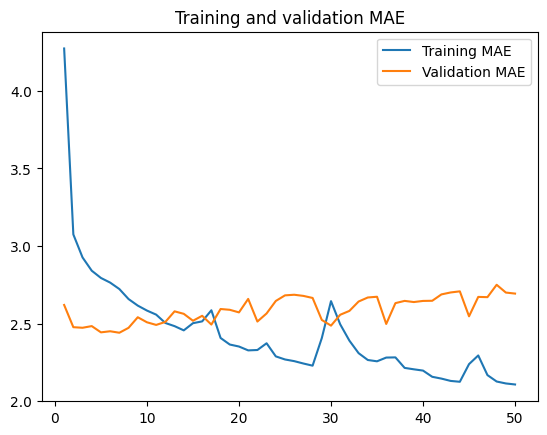

In [37]:
plot_history(history)

In [38]:
model = keras.models.load_model(MODELS_DIR / "jena_lstm_no_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 10.5629 - mae: 2.5693
Test MAE: 2.56


#### Training and evaluating an L2-regularized LSTM

There is also such a thing as a `recurrent_regularizer`! (Works as usual.)

In [39]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
                           # ↓ recurrent regularizer
x = keras.layers.LSTM(32, recurrent_regularizer=keras.regularizers.L2(0.3))(inputs)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [40]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        str(MODELS_DIR / "jena_lstm_l2.keras"),
        save_best_only=True
    )
]
model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=0,
)

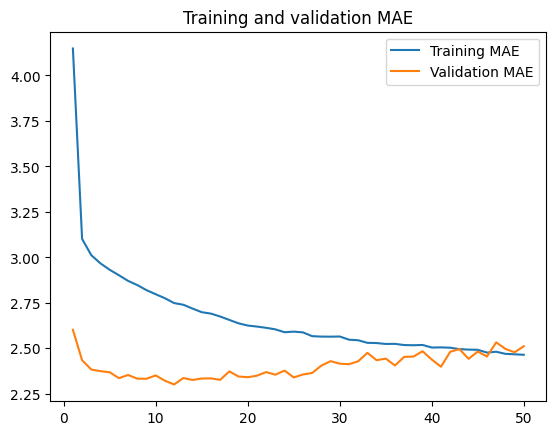

In [41]:
plot_history(history)

In [42]:
model = keras.models.load_model(MODELS_DIR / "jena_lstm_l2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 10.2314 - mae: 2.4823
Test MAE: 2.47


---

### Stacking recurrent layers

#### Training and evaluating a dropout-regularized, stacked GRU model

Just as with the `LSTM` earlier, the `recurrent_dropout`, not (yet?) being supported by optimised low-level CUDA operations, is very slow:

```python

keras.utils.clear_session()

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
                                                #  we return all inner states
x = keras.layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = keras.layers.GRU(32, recurrent_dropout=0.5)(x) # Note: recurrent_dropout is INSANELY slow!!
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        str(MODELS_DIR / "jena_stacked_gru_dropout.keras"),
        save_best_only=True
    )
]
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=0,
)

plot_history(history)

model = keras.models.load_model(MODELS_DIR / "jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
```

#### Training and evaluating an L2-regularized, stacked GRU model

In [43]:
keras.utils.clear_session()

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))           # we return all inner states
x = keras.layers.GRU(32, recurrent_regularizer=keras.regularizers.l2(0.8), return_sequences=True)(inputs)
x = keras.layers.GRU(32, recurrent_regularizer=keras.regularizers.l2(0.8))(x)
x = keras.layers.Dropout(0.5)(x) # ↑ the L2 regularizer works with cuDNN
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [44]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        str(MODELS_DIR / "jena_stacked_gru_l2.keras"),
        save_best_only=True
    )
]
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=0
)

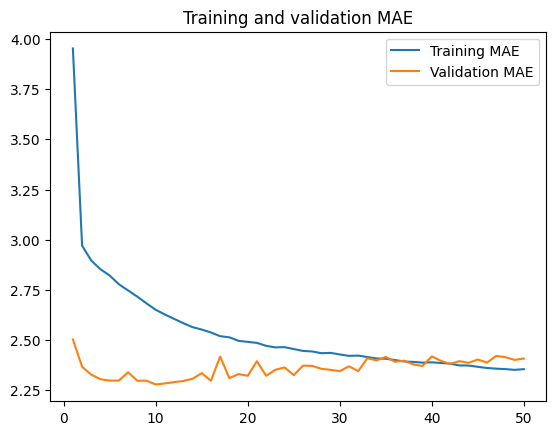

In [45]:
plot_history(history)

In [46]:
model = keras.models.load_model(MODELS_DIR / "jena_stacked_gru_l2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 9.8414 - mae: 2.4415
Test MAE: 2.43


---

### Using bidirectional RNNs

RNNs exploit patterns in data that has a definite order (like weather readings).

But the **reverse** of an ordered list is still ordered and might hold pertinent information.

The idea is to train one net on sequential data, then another one with **the same hyperparameters** on the same dataset but with the order *reversed*.

The hypothesis is that word order *does* matter in understanding language but *which* order (forward or back) isn't critical (on the basis if this single experiment).

An RNN trained on a reversed sequence will learn different representations than one trained on the original sequence.

Representations that are *different* yet *useful* are always worth exploiting. The more they differ the better!

Alternative representations can capture aspects of the data that were missed by other approaches.

**Note**

This is the intuition behind *ensembling* (gathering predictions from several models).

A bidirectional RNN is two regular RNNs: one chronological, the other antichronological. Representations are merged at the end.

Strong suit: create representations for the whole sentence (e.g. for sentiment).  
However: cannot be used to predict the next token!

<!-- ![bidirectional rnn](images/chollet/figure13.13.png) -->
![bidirectional rnn](https://raw.githubusercontent.com/jchwenger/DLWP/main/lectures/07/images/chollet/figure13.13.png)

[DLWP](https://deeplearningwithpython.io/chapters/chapter13_timeseries-forecasting/#using-bidirectional-rnns), Figure 13.13

#### Training and evaluating a bidirectional LSTM

In [47]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
                  # ↓ BIDIRECTIONAL -------------------------------
x = keras.layers.Bidirectional(keras.layers.LSTM(16))(inputs)
                  # ------------- ↑ wrapping an RNN layer ---------
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [48]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        str(MODELS_DIR / "jena_lstm_bidirectional.keras"),
        save_best_only=True
    )
]

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=0,
)

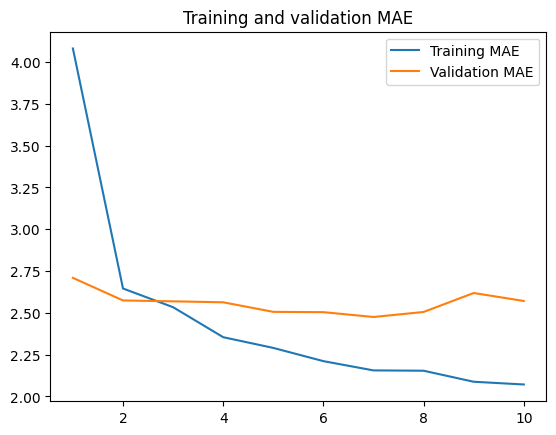

In [49]:
plot_history(history)

In [50]:
model = keras.models.load_model(MODELS_DIR / "jena_lstm_bidirectional.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 11.0192 - mae: 2.6195
Test MAE: 2.62


## Save models to Google Drive

In [53]:
EXPORT=False

if EXPORT:
    # zip models
    !zip jena.models.zip {MODELS_DIR}/*
    # connect to drive
    from google.colab import drive
    drive.mount('/content/drive')
    # copy zip to drive (adjust folder as needed)
    !cp jena.models.zip drive/MyDrive/gold/IS53024B-Artificial-Intelligence/models

---

## Summary & Experiments

### Going even further

- Experiment with the number of units in recurrent layers, and with the l2 regularizer;
- Experiment with the optimizer and learning rate;
- Try and have a stack of Dense layers instead of just one;
- Vary the length of input sequences, try a different sampling rate, or think about feature engineering.

### As always

- *Baselines, baselines, baselines*;
- Try simple models, then more complex ones;

### RNNs

- Recurrent nets work well for data where **ordering** matters;
- Two main layers:
  - **LSTM**: most complex, most expensive;
  - **GRU**: slightly less complex, faster;
- For recurrent nets use the time-constant `recurrent_dropout` (slow!) or the `recurrent_regularizer`;
- For more representational power, try **stacking** RNN layers
- If you're not predicting future steps, you can try **bidirectional** layers.